In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch.utils.data import Dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

In [ ]:
train_data = datasets.ImageFolder("../dataset/pizza_steak_sushi/train", transform=transform, target_transform=None)
test_data = datasets.ImageFolder("../dataset/pizza_steak_sushi/test",)

In [5]:
train_data.classes

['pizza', 'steak', 'sushi']

In [6]:
BATCH_SIZE = 16
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# img, lable = next(iter(train_data_loader))

In [8]:
# plt.imshow(img[0].permute(1,2,0)), lable

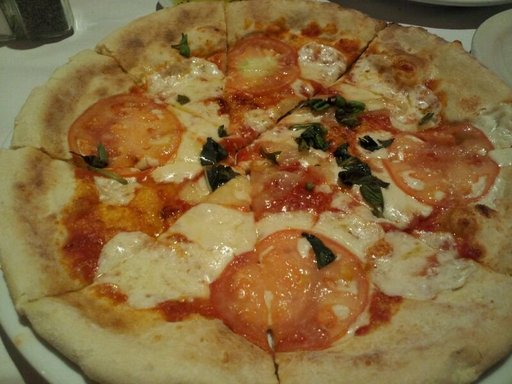

In [ ]:
from PIL import Image
Image.open("../dataset/pizza_steak_sushi/train/pizza/0.jpg")

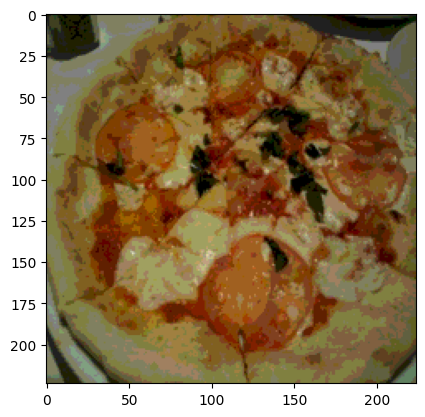

In [ ]:
plt.imshow(transform(Image.open("../dataset/pizza_steak_sushi/train/pizza/0.jpg")).permute(1,2,0))

In [13]:
def acc_fn(y_preds, y):
    # print(y_preds)
    acc_score = torch.eq(y_preds, y).sum() / len(y)
    return acc_score

In [14]:
# torch.cuda.manual_seed_all(42)
# class ResidualBlock(nn.Module):
#         def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
#             super(ResidualBlock, self).__init__()
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU())
#             self.conv2 = nn.Sequential(
#                             nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
#                             nn.BatchNorm2d(out_channels))
#             self.downsample = downsample    
#             self.relu = nn.ReLU()
#             self.out_channels = out_channels

#         def forward(self, x):
#             residual = x
#             out = self.conv1(x)
#             out = self.conv2(out)
#             if self.downsample:
#                 residual = self.downsample(x)
#             out += residual
#             out = self.relu(out)
#             return out

# class ResNet34(nn.Module):
#         def __init__(self, block, layers, num_classes = 10):
#             super().__init__()
#             self.inplanes = 64
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
#                             nn.BatchNorm2d(64),
#                             nn.ReLU())
#             self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
#             self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
#             self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
#             self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
#             self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
#             self.avgpool = nn.AvgPool2d(7, stride=1)
#             self.fc = nn.Linear(512, num_classes)

#         def _make_layer(self, block, planes, blocks, stride=1):
#             downsample = None
#             if stride != 1 or self.inplanes != planes:

#                 downsample = nn.Sequential(
#                     nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
#                     nn.BatchNorm2d(planes),
#                 )
#             layers = []
#             layers.append(block(self.inplanes, planes, stride, downsample))
#             self.inplanes = planes
#             for i in range(1, blocks):
#                 layers.append(block(self.inplanes, planes))

#             return nn.Sequential(*layers)

#         def forward(self, x):
#             x = self.conv1(x)
#             x = self.maxpool(x)
#             x = self.layer0(x)
#             x = self.layer1(x)
#             x = self.layer2(x)
#             x = self.layer3(x)

#             x = self.avgpool(x)
#             x = x.view(x.size(0), -1)
#             x = self.fc(x)

#             return x
        

In [15]:
class ResidualBlockResNet50Above(nn.Module):
    def __init__(self, in_chan, interm_chan, identiti_downsample=None, stride = 1) -> None:
        super().__init__()
        self.expansion = 4
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_chan, interm_chan, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(interm_chan),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(interm_chan, interm_chan, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(interm_chan),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(interm_chan, interm_chan*self.expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(interm_chan*self.expansion)
        )
        self.identiti_downsample = identiti_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        identiti = x.clone()

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        if self.identiti_downsample is not None:
            identiti = self.identiti_downsample(identiti)
        
        x += identiti
        x = self.relu(x)
        return x

class ResNet650Above(nn.Module):
    def __init__(self, Residual_block , layers, num_classes) -> None:
        super().__init__()
        self.in_channels = 64
        self.base_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(Residual_block, layers[0], inter_chan=64, stride=1) 
        self.layer2 = self._make_layer(Residual_block, layers[1], inter_chan=128, stride=2) 
        self.layer3 = self._make_layer(Residual_block, layers[2], inter_chan=256, stride=2) 
        self.layer4 = self._make_layer(Residual_block, layers[3], inter_chan=512, stride=2) 

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.base_layer(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


    def _make_layer(self, block, no_res_block, inter_chan, stride):
        indentit_downsample = None
        layers = []
        if stride != 1 or self.in_channels != inter_chan*4:
            indentit_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    inter_chan * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(inter_chan * 4),
            )
        
        layers.append(block(self.in_channels, inter_chan, indentit_downsample, stride))

        self.in_channels = inter_chan*4

        for i in range(no_res_block-1):
            layers.append(block(self.in_channels, inter_chan))

        return nn.Sequential(*layers)
# class block(nn.Module):
#     def __init__(
#         self, in_channels, intermediate_channels, identity_downsample=None, stride=1
#     ):
#         super().__init__()
#         self.expansion = 4
#         self.conv1 = nn.Conv2d(
#             in_channels,
#             intermediate_channels,
#             kernel_size=1,
#             stride=1,
#             padding=0,
#             bias=False,
#         )
#         self.bn1 = nn.BatchNorm2d(intermediate_channels)
#         self.conv2 = nn.Conv2d(
#             intermediate_channels,
#             intermediate_channels,
#             kernel_size=3,
#             stride=stride,
#             padding=1,
#             bias=False,
#         )
#         self.bn2 = nn.BatchNorm2d(intermediate_channels)
#         self.conv3 = nn.Conv2d(
#             intermediate_channels,
#             intermediate_channels * self.expansion,
#             kernel_size=1,
#             stride=1,
#             padding=0,
#             bias=False,
#         )
#         self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
#         self.relu = nn.ReLU()
#         self.identity_downsample = identity_downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x.clone()

#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)

#         if self.identity_downsample is not None:
#             identity = self.identity_downsample(identity)

#         x += identity
#         x = self.relu(x)
#         return x


# class ResNet(nn.Module):
#     def __init__(self, block, layers, image_channels, num_classes):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(
#             image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
#         )
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # Essentially the entire ResNet architecture are in these 4 lines below
#         self.layer1 = self._make_layer(
#             block, layers[0], intermediate_channels=64, stride=1
#         )
#         self.layer2 = self._make_layer(
#             block, layers[1], intermediate_channels=128, stride=2
#         )
#         self.layer3 = self._make_layer(
#             block, layers[2], intermediate_channels=256, stride=2
#         )
#         self.layer4 = self._make_layer(
#             block, layers[3], intermediate_channels=512, stride=2
#         )

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * 4, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.reshape(x.shape[0], -1)
#         x = self.fc(x)

#         return x

#     def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
#         identity_downsample = None
#         layers = []

#         # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
#         # we need to adapt the Identity (skip connection) so it will be able to be added
#         # to the layer that's ahead
#         if stride != 1 or self.in_channels != intermediate_channels * 4:
#             identity_downsample = nn.Sequential(
#                 nn.Conv2d(
#                     self.in_channels,
#                     intermediate_channels * 4,
#                     kernel_size=1,
#                     stride=stride,
#                     bias=False,
#                 ),
#                 nn.BatchNorm2d(intermediate_channels * 4),
#             )

#         layers.append(
#             block(self.in_channels, intermediate_channels, identity_downsample, stride)
#         )

#         # The expansion size is always 4 for ResNet 50,101,152
#         self.in_channels = intermediate_channels * 4

#         # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
#         # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
#         # and also same amount of channels.
#         for i in range(num_residual_blocks - 1):
#             layers.append(block(self.in_channels, intermediate_channels))

#         return nn.Sequential(*layers)


In [16]:
# class TinyNet1(nn.Module):
#     def __init__(self, *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)
#         self.input_layer = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU()
#         )
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(256*32*32, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 3)
#         )
    
#     def forward(self, x):
#         x = self.input_layer(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         # print(x.shape)
#         # print(x.shape)
#         x = self.fc(x)
#         return x


In [17]:
# res_net1 = ResNet34(ResidualBlock, [3,4,6,3], num_classes=3).to(device)
res_net1 = ResNet650Above(ResidualBlockResNet50Above, [3,4,6,3], num_classes=3).to(device)
# res_net1 = TinyNet1().to(device)

In [18]:
# res_net1 = ResNet(block, [3, 4, 6, 3], 3, 3).to(device)

In [19]:
res_net1.parameters

<bound method Module.parameters of ResNet650Above(
  (base_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlockResNet50Above(
      (layer1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (layer2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (layer3): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): 

In [20]:
!pip install torchinfo

In [21]:
from torchinfo import summary
summary(res_net1, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet650Above                                [16, 3]                   --
├─Sequential: 1-1                             [16, 64, 56, 56]          --
│    └─Conv2d: 2-1                            [16, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [16, 64, 112, 112]        128
│    └─ReLU: 2-3                              [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [16, 64, 56, 56]          --
├─Sequential: 1-2                             [16, 256, 56, 56]         --
│    └─ResidualBlockResNet50Above: 2-5        [16, 256, 56, 56]         --
│    │    └─Sequential: 3-1                   [16, 64, 56, 56]          4,224
│    │    └─Sequential: 3-2                   [16, 64, 56, 56]          36,992
│    │    └─Sequential: 3-3                   [16, 256, 56, 56]         16,896
│    │    └─Sequential: 3-4                   [16, 256, 56, 56]         16,896
│

In [22]:
loss_fn = nn.CrossEntropyLoss().to(device)
optim_fn = torch.optim.RMSprop(res_net1.parameters(), lr = 3e-4)

In [23]:
total_param = 0
for i in res_net1.parameters():
    total_param+=i.numel()
print(total_param)

23514179


In [24]:
import gc

In [25]:
all_train_acc = []
all_test_acc = []
all_train_loss = []
all_test_loss = []

In [26]:
from tqdm import tqdm
epochs = 250
for e in range(epochs):
    total_train_loss = 0
    total_train_acc = 0
    total_test_loss = 0
    total_test_acc = 0
    for img, label in tqdm(train_data_loader):
        res_net1.train()
        img = img.to(device)
        label = label.to(device)
        y_logits = res_net1(img)
        train_loss = loss_fn(y_logits, label)

        # print(train_loss.item())

        total_train_loss += train_loss.item()

        total_train_acc += acc_fn(torch.argmax(y_logits, dim=1), label)

        optim_fn.zero_grad()
        train_loss.backward()
        optim_fn.step()

        del img, label, y_logits, train_loss

    torch.cuda.empty_cache()
    gc.collect()

    for img, label in tqdm(test_data_loader):
        res_net1.eval()
        img = img.to(device)
        label = label.to(device)
        y_logits = res_net1(img)
        test_loss = loss_fn(y_logits, label)

        total_test_loss += test_loss.item()

        total_test_acc += acc_fn(torch.argmax(y_logits, dim=1), label)

        del img, label, y_logits, test_loss

    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"Epoch {e} Train Loss: {total_train_loss/len(train_data_loader)} Train Acc: {total_train_acc/len(train_data_loader)}")
    print(f"Epoch {e} Test Loss: {total_test_loss/len(test_data_loader)} Test Acc: {total_test_acc/len(test_data_loader)}")
    all_train_acc.append(total_train_acc/len(train_data_loader))
    all_test_acc.append(total_test_acc/len(test_data_loader))

    all_train_loss.append(total_train_loss/len(train_data_loader))
    all_test_loss.append(total_test_loss/len(test_data_loader))

100%|██████████| 47/47 [00:03<00:00, 12.43it/s]


Epoch 157 Train Loss: 0.198626785558906 Train Acc: 0.9332445859909058
Epoch 157 Test Loss: 0.3609976538635315 Test Acc: 0.8628419041633606


100%|██████████| 47/47 [00:03<00:00, 12.16it/s]


Epoch 158 Train Loss: 0.1950191939844096 Train Acc: 0.9286347031593323
Epoch 158 Test Loss: 1.4299482297390065 Test Acc: 0.6738221645355225


  0%|          | 0/141 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [27]:
all_train_acc = [x.item() for x in all_train_acc]
all_test_acc = [x.item() for x in all_test_acc]


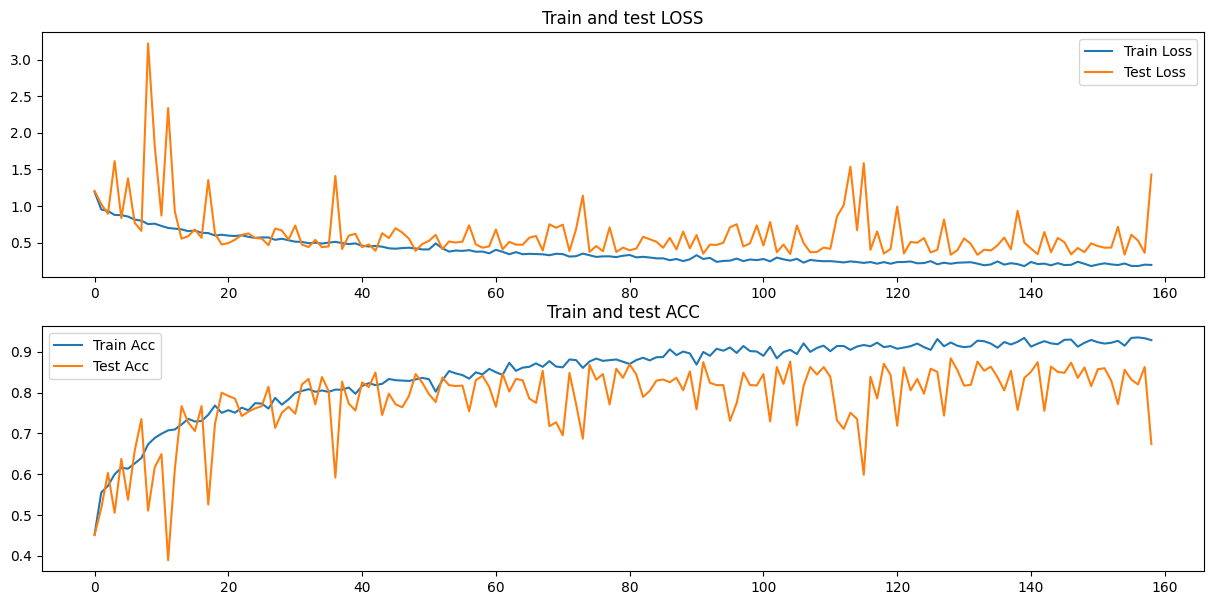

In [39]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)

plt.plot(all_train_loss, label = "Train Loss")
plt.plot(all_test_loss, label = "Test Loss")
plt.title("Train and test LOSS")
plt.legend()

plt.subplot(2,1,2)
plt.plot(all_train_acc, label = "Train Acc")
plt.plot(all_test_acc, label = "Test Acc")
plt.title("Train and test ACC")
plt.legend()
plt.show()

In [98]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
test_data = datasets.ImageFolder("../dataset/pizza_steak_sushi/test",transform=test_transform)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [102]:
total_test_acc = 0
total_test_loss = 0
for img, label in tqdm(test_data_loader):
        res_net1.eval()
        img = img.to(device)
        label = label.to(device)
        y_logits = res_net1(img)
        test_loss = loss_fn(y_logits, label)

        total_test_loss += test_loss.item()

        total_test_acc += acc_fn(torch.argmax(y_logits, dim=1), label)

        del img, label, y_logits, test_loss

print(total_test_loss/len(test_data_loader), total_test_acc/len(test_data_loader))

100%|██████████| 47/47 [00:03<00:00, 12.49it/s]

1.3599818926700886 tensor(0.6995, device='cuda:0')


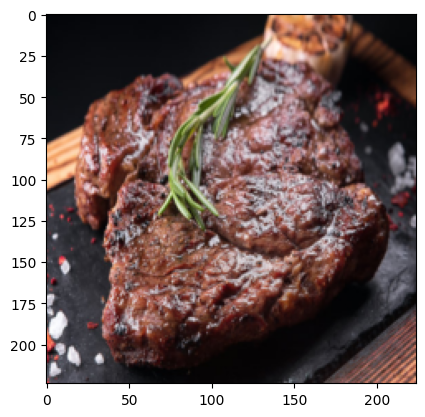

In [123]:
img_tensor = test_transform(Image.open("./stake.jpg"))
plt.imshow(img_tensor.permute(1,2,0))

In [124]:
img_tensor = img_tensor / 255.

In [129]:
img_tensor

tensor([[[[7.6894e-05, 7.6894e-05, 7.6894e-05,  ..., 1.2303e-04,
           1.2303e-04, 1.2303e-04],
          [6.1515e-05, 6.1515e-05, 6.1515e-05,  ..., 1.2303e-04,
           1.2303e-04, 1.2303e-04],
          [6.1515e-05, 6.1515e-05, 6.1515e-05,  ..., 1.2303e-04,
           1.2303e-04, 1.2303e-04],
          ...,
          [1.7532e-03, 2.2760e-03, 1.3072e-03,  ..., 2.1838e-03,
           3.2295e-03, 3.7678e-03],
          [1.9992e-03, 2.0761e-03, 1.3379e-03,  ..., 3.1834e-03,
           3.5063e-03, 3.3679e-03],
          [3.3372e-03, 3.0604e-03, 1.6301e-03,  ..., 3.4141e-03,
           3.1834e-03, 2.2914e-03]],

         [[6.1515e-05, 6.1515e-05, 6.1515e-05,  ..., 1.3841e-04,
           1.3841e-04, 1.3841e-04],
          [7.6894e-05, 7.6894e-05, 7.6894e-05,  ..., 1.3841e-04,
           1.3841e-04, 1.3841e-04],
          [9.2272e-05, 9.2272e-05, 9.2272e-05,  ..., 1.3841e-04,
           1.3841e-04, 1.3841e-04],
          ...,
          [1.5532e-03, 1.4148e-03, 1.2149e-03,  ..., 1.3226

In [125]:
img_tensor = img_tensor.unsqueeze(dim=0)
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [126]:
img_tensor = img_tensor.to(device)

In [127]:
res_net1.eval()
train_data.classes


['pizza', 'steak', 'sushi']

In [128]:
torch.argmax(res_net1(img_tensor), dim=1)

tensor([0], device='cuda:0')